In [199]:
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import StandardScaler
from matplotlib import cm, colors, colorbar
import mne
from sklearn.svm import SVC
import scipy.stats as stats
from scipy.io import savemat
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

from sklearn.model_selection import ShuffleSplit, GroupShuffleSplit, cross_val_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, plot_confusion_matrix

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression

import seaborn as sns

import scipy.io as sio

In [29]:
data_folder = "/data/tvanasse/nccam3/data/"

In [30]:
# acquire features by averaging in 5 spatial clusters

def parcellate_features(features):
    
    raw = mne.io.read_raw_eeglab('/data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.set')

    ## ONLY FOR PLOTTING, MNE reads positions as meters
    for i in range(len(raw.info['chs'])):
        raw.info['chs'][i]['loc'] = raw.info['chs'][i]['loc']/121

    # feature parcellation
    hist_bins = [["26","27","20","21","28","15","22","14","13","34","33","12","19",
                  "16","23","29","35","36","30","24","42","41","49","48","40","39",
                  "7","6","5","4","3","224","215","207","214","213","222","206","39","223"],

                 ["56","63","57","44","43","53","52","51","60","59","58","65","64","50",
                  "212","205","203","204","144","185","197","155","184","196","195","183","182","194"],


                 ["81","80","131","130","129","101","100","89","90","79","78","77","88","87","86","85","76","72",
                  "66","84","143","154","163","142","153","162","164","173","172","171","179"],

                 ["110","99","109","108","98","97","107","115","114","106","96","95","105",
                  "128","141","140","151","152","161","160","159","169","168","170","178","177",
                  "119","118","117","126","139","127","125","138","137","116","124","149","150","136","148"],

                 ["8","17","9","45","132","186","198"]
                 ]

    groups = []
    for ch_names in hist_bins:
        indices = [raw.ch_names.index(ch_name) for ch_name in ch_names]
        groups.append(indices)

    inside185ch = sio.loadmat('../channel_location_file/inside185ch.mat')

    #256 labels/indices
    parcels_256labels = {"Frontal": np.array(list(map(int,hist_bins[0]))),
         "Temporal": np.array(list(map(int,hist_bins[1]))),
         "Parietal":np.array(list(map(int,hist_bins[2]))),
         "Occipital":np.array(list(map(int,hist_bins[3]))),
         "Central":np.array(list(map(int,hist_bins[4])))
         }

    #256 labels to 185indices
    parcels_185indices = {}

    for parcel in list(parcels_256labels.keys()):
        translate = []

        for i in range(0,len(parcels_256labels[parcel])):
            translate.append(np.where(np.squeeze(inside185ch['inside185ch']) == parcels_256labels[parcel][i])[0][0])

        parcels_185indices.update({parcel:np.array(list(map(int,translate)))})

    features_parc = features

    features_parc = np.stack((np.mean(features_parc[:, parcels_185indices["Frontal"]],axis=1),
              np.mean(features_parc[:, parcels_185indices["Temporal"]],axis=1),
              np.mean(features_parc[:, parcels_185indices["Parietal"]],axis=1),
              np.mean(features_parc[:, parcels_185indices["Occipital"]],axis=1),
              np.mean(features_parc[:, parcels_185indices["Central"]],axis=1)
             ),axis=1)
    
    return features_parc
                

In [31]:
# function to load windowed (15 sec. increments) spectral exponent data before awakening
# this data is in .mat files, spectral exponent was calculatd according to Columbo et al. 2019:
# https://github.com/milecombo/spectralExponent/blob/master/ README.md.

def load_specexp_windowed(timerange_list):
    
    data_folder = '/data/tvanasse/nccam3/data/post_process_data/windowed_specexps/'
    
    nrem_dataframe = pd.read_csv('nrem_dataframe.csv')
    
    for timerange in timerange_list:
        print("Timerange: " + str(timerange))
        
        nrem_dataframe["SPECEXP_1-40_ALL_" + str(timerange)] = np.array(0).astype('object') #create object for 
        nrem_dataframe["INTERCEPT_1-40_ALL_" + str(timerange)] = np.array(0).astype('object') #create object for 
        nrem_dataframe["OBS_1-40_" + str(timerange)] = np.array(0).astype('object') #create object for 
        nrem_dataframe["OBS_1-40_ALL_" + str(timerange)] = np.array(0).astype('object') #create object for 
        nrem_dataframe["FREQ_1-40"] = np.array(0).astype('object') #create object for 
        
        nrem_dataframe["SPECEXP_20-40_ALL_" + str(timerange)] = np.array(0).astype('object') #create object for 
        nrem_dataframe["INTERCEPT_20-40_ALL_" + str(timerange)] = np.array(0).astype('object') #create object for 
        nrem_dataframe["OBS_20-40_" + str(timerange)] = np.array(0).astype('object') #create object for 
        nrem_dataframe["OBS_20-40_ALL_" + str(timerange)] = np.array(0).astype('object') #create object for 
        nrem_dataframe["FREQ_20-40"] = np.array(0).astype('object') #create object for 
        
        nrem_dataframe["SPECEXP_1-20_ALL_" + str(timerange)] = np.array(0).astype('object') #create object for 
        nrem_dataframe["INTERCEPT_1-20_ALL_" + str(timerange)] = np.array(0).astype('object') #create object for 
        nrem_dataframe["OBS_1-20_" + str(timerange)] = np.array(0).astype('object') #create object for 
        nrem_dataframe["OBS_1-20_ALL_" + str(timerange)] = np.array(0).astype('object') #create object for 
        nrem_dataframe["FREQ_1-20"] = np.array(0).astype('object') #create object for 
  
        from scipy.io import loadmat

        for awak in range(0,len(nrem_dataframe)):
            annots = loadmat(data_folder + str(nrem_dataframe.loc[awak,'ID']) + "_" + str(nrem_dataframe.loc[awak,'Visit']) +\
                            "_" + str(int(nrem_dataframe.loc[awak,'ENTRY_MATCHED_AWAKENING_NO'])))

            # get spectral exponents & set timerange (1 or 2 minutes before awakening)
            for i in range(0,annots['output'].shape[1]):
                if (str(annots['output']['freqrange'][0][i][0]) == '[ 1 40]') & (annots['output']['timerange'][0][i][0][0] == timerange):
                    nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values,"SPECEXP_1-40_" + str(timerange)] = annots['output']['meanspectralexp'][0][i][0][0]
                    nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values,"INTERCEPT_1-40"] = annots['output']['meanintercept'][0][i][0][0]

                    nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"SPECEXP_1-40_ALL_" + str(timerange)] = annots['output']['spectralexp_all'][0][i][0].tolist()
                    nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"INTERCEPT_1-40_ALL_" + str(timerange)] = annots['output']['intercept_all'][0][i][0].tolist()
                    nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"OBS_1-40_" + str(timerange)] = annots['output']['obs_freq_avg'][0][i][0].tolist()
                    nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"OBS_1-40_ALL_" + str(timerange)] = annots['output']['obs_freq_all'][0][i][0].tolist()
                    nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"FREQ_1-40"] = annots['output']['freqbins'][0][i][0].tolist()
                    
                elif (str(annots['output']['freqrange'][0][i][0]) == '[20 40]') & (annots['output']['timerange'][0][i][0][0] == timerange):
                    nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values,"SPECEXP_20-40_" + str(timerange)] = annots['output']['meanspectralexp'][0][i][0][0]
                    nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values,"INTERCEPT_20-40"] = annots['output']['meanintercept'][0][i][0][0]
                    
                    nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"SPECEXP_20-40_ALL_" + str(timerange)] = annots['output']['spectralexp_all'][0][i][0].tolist()
                    nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"INTERCEPT_20-40_ALL_" + str(timerange)] = annots['output']['intercept_all'][0][i][0].tolist()
                    nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"OBS_20-40_" + str(timerange)] = annots['output']['obs_freq_avg'][0][i][0].tolist()
                    nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"OBS_20-40_ALL_" + str(timerange)] = annots['output']['obs_freq_all'][0][i][0].tolist()
                    nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"FREQ_20-40"] = annots['output']['freqbins'][0][i][0].tolist()
                    
                elif (str(annots['output']['freqrange'][0][i][0]) == '[ 1 20]') & (annots['output']['timerange'][0][i][0][0] == timerange):
                    nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values,"SPECEXP_20-40_" + str(timerange)] = annots['output']['meanspectralexp'][0][i][0][0]
                    nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values,"INTERCEPT_20-40"] = annots['output']['meanintercept'][0][i][0][0]

                    nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"SPECEXP_1-20_ALL_" + str(timerange)] = annots['output']['spectralexp_all'][0][i][0].tolist()
                    nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"INTERCEPT_1-20_ALL_" + str(timerange)] = annots['output']['intercept_all'][0][i][0].tolist()
                    nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"OBS_1-20_" + str(timerange)] = annots['output']['obs_freq_avg'][0][i][0].tolist()
                    nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"OBS_1-20_ALL_" + str(timerange)] = annots['output']['obs_freq_all'][0][i][0].tolist()
                    nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"FREQ_1-20"] = annots['output']['freqbins'][0][i][0].tolist()


    return nrem_dataframe


In [32]:
nrem_dataframe = load_specexp_windowed([0.25,0.5,0.75,1,1.25,1.50,1.75,2,2.25,2.5])

 ## filters data with report or something and no report
check = np.load('./sub_q1_data/sub_reportorsomethingandnoreport_min1.npy')
print(check)
nrem_dataframe = nrem_dataframe[nrem_dataframe.ID.isin(check)].reset_index(drop=True)
nrem_dataframe = nrem_dataframe[nrem_dataframe['DIN_EVENTS_WITHIN_TWO_MINUTES'] == 1].reset_index(drop=True)


# assign either 0 (NoReport) or 1 (Report or Something) for concious experience
nrem_dataframe["REPORT_BINARY"] = 0
nrem_dataframe.loc[nrem_dataframe[(nrem_dataframe["Q1Experience"] != "NoReport")].index,
                       "REPORT_BINARY"] = 1

print(len(nrem_dataframe))

Timerange: 0.25
Timerange: 0.5
Timerange: 0.75
Timerange: 1
Timerange: 1.25
Timerange: 1.5
Timerange: 1.75
Timerange: 2
Timerange: 2.25
Timerange: 2.5
[2000 2001 2002 2004 2005 2006 2008 2010 2011 2012 2013 2016 2019 2022
 2023 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2037 2041 2043
 2045 2046 2047 2048 2049 2051 2052 2053 2054 2055 2056 2058 2059 2060
 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2075
 2078 2079 2080 2083 2085 2086 2087 2088 2091 2092 2094 2095 2096 2100
 2101 2102 2103 2104 2105 2106 2107 2108 2111 2112 2114 2115 2116 2121
 2122 2123 2126 2127 2128 2133 2134 2140 2142 2144]
1092


In [50]:
# save dataframe to pickle file
nrem_dataframe.to_pickle('safmri_dataframe_FEATURES_WINDOWED.pkl')

In [191]:
nrem_dataframe = pd.read_pickle('safmri_dataframe_FEATURES_WINDOWED.pkl')

<AxesSubplot:>

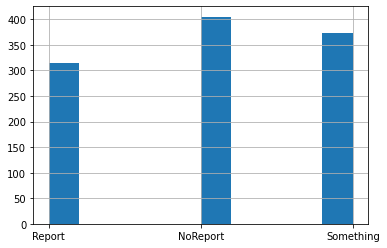

In [192]:
# let's take a look at the target variables
nrem_dataframe['Q1Experience'].hist()

<AxesSubplot:>

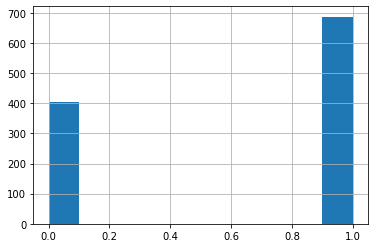

In [193]:
nrem_dataframe['REPORT_BINARY'].hist()

In [203]:
# training/testing split for hyperparameter search (nested cv with group k-fold according to subject id)

def svm_function(n_jobs,features,y,groups,random_state,type_svm,scoring,class_weight):
    
    if class_weight == "balanced":
        clf = LogisticRegression(class_weight="balanced")
        p_grid = {'C': [0.00001,0.0001,0.001,0.01,0.1,1,5,10,100,1000]}
        
#         clf = RandomForestClassifier()
#         p_grid = {'bootstrap': [True, False],
#                  'max_depth': [10, 50, 100],
#                  'max_features': ['auto', 'sqrt'],
#                  'min_samples_leaf': [1, 2],
#                  'min_samples_split': [2, 5, 10],
#                  'n_estimators': [200, 400, 600,]}
             
    else:
        clf = LogisticRegression()        
        p_grid = {'C': [0.00001,0.0001,0.001,0.01,0.1,1,5,10,100,1000]}
        
#         clf = RandomForestClassifier()
#         p_grid = {'bootstrap': [True, False],
#                  'max_depth': [10, 50, 100],
#                  'max_features': ['auto', 'sqrt'],
#                  'min_samples_leaf': [1, 2],
#                  'min_samples_split': [2, 5, 10],
#                  'n_estimators': [200, 400, 600,]}

    inner_cv = GroupKFold(n_splits=10)
    outer_cv = GroupKFold(n_splits=10)
    
    nested_score = []
    first_iter = 1
    for train_index, test_index in outer_cv.split(features, y, groups=groups):
        features_train, features_test = features[train_index], features[test_index]
        y_train, y_test = y[train_index], y[test_index]

        grid = RandomizedSearchCV(estimator=clf,
                                    param_distributions=p_grid,
                                    cv=inner_cv,
                                    scoring=scoring,
                                    return_train_score=True,
                                    random_state=random_state,
                                    n_jobs=n_jobs)
        
        grid.fit(features_train, y_train, groups=groups[train_index])

        prediction = grid.predict(features_test)

        if scoring == 'balanced_accuracy':
            nested_score.append(balanced_accuracy_score(y_test, prediction))
        elif scoring == 'accuracy':
            nested_score.append(accuracy_score(y_test, prediction))

    nested_score = np.array(nested_score)
    
    print("nested_score: ")
    print(nested_score)
    print(nested_score.mean())
    
    return np.array(nested_score)

In [ ]:
# create null distribution by label switching

for timerange in [0.25,0.5,0.75,1,1.25,1.50,1.75,2,2.25,2.5]:
    reduced_dataframe = nrem_dataframe[nrem_dataframe["SPECEXP_1-40_ALL_" + str(timerange)] != 0].reset_index(drop=True)

    # spectral exponent features
    features = np.vstack(reduced_dataframe["SPECEXP_1-40_ALL_" + str(timerange)].values)
    print("features: " + str(features.shape))

    features = parcellate_features(features)
    print("features: " + str(features.shape))

    # other spectral features
    feature_add = np.vstack(reduced_dataframe["SPECEXP_20-40_ALL_" + str(timerange)].values)
    print("features: " + str(features.shape))
    feature_add = parcellate_features(feature_add)
    print("features: " + str(features.shape))
    features = np.concatenate((features,feature_add),axis=1)
    print("features: " + str(features.shape))

    # other spectral features
    feature_add = np.vstack(reduced_dataframe["SPECEXP_1-20_ALL_" + str(timerange)].values)
    print("features: " + str(features.shape))
    feature_add = parcellate_features(feature_add)
    print("features: " + str(features.shape))
    features = np.concatenate((features,feature_add),axis=1)
    print("features: " + str(features.shape))


    groups = reduced_dataframe["ID"].values
    print("groups: " + str(groups.shape))

    # STANDARDIZE FEATURES
    features = preprocessing.scale(features)

    for class_no in ["multi","binary"]:

        # get null distribution from N iterations
        N = 250
        nested_score_shuff = []
        for i in range(0,N): # shuffle labels
            print("iter: " + str(i))
            y_shuff = np.array([])
            if class_no == "binary":
                x = reduced_dataframe["REPORT_BINARY"].values
                scoring = "balanced_accuracy"
                class_weight = "balanced"

            elif class_no == "multi":
                x = reduced_dataframe["Q1ExperienceNum"].values
                scoring = "balanced_accuracy"
                class_weight = "balanced"

            np.random.shuffle(x)
            y_shuff = x

            # def svm_function(n_jobs,features,y,groups,type_svm):
            nested_score_iter = svm_function(50,
                                        features,
                                        y_shuff,
                                        reduced_dataframe["ID"].values,
                                        np.random.randint(1000),
                                        "svm",
                                        scoring=scoring,
                                        class_weight=class_weight)
            
            nested_score_shuff.append(np.mean(nested_score_iter))

        np.save('/data/tvanasse/nccam3/data/post_process_data/windowed_specexps/shuff/' +\
                str(N) + "_" + class_no + "_window" + str(timerange) + ".npy", nested_score_shuff)

In [35]:
N = 250 

# load shuffled accuracies
top_percentiles_binary = []
bot_percentiles_binary = []
mean_binary = []

top_percentiles_multi = []
bot_percentiles_multi = []
mean_multi = []

for timerange in [0.25,0.5,0.75,1,1.25,1.50,1.75,2,2.25,2.5]:
    
    nested_score_shuff = np.load('/data/tvanasse/nccam3/data/post_process_data/windowed_specexps/shuff/' +\
                str(N) + "_" + "binary" + "_window" + str(timerange) + ".npy")
    top_percentiles_binary.append(np.percentile(nested_score_shuff, 95))
    bot_percentiles_binary.append(np.percentile(nested_score_shuff, 5))
    mean_binary.append(np.mean(nested_score_shuff))
    
    nested_score_shuff = np.load('/data/tvanasse/nccam3/data/post_process_data/windowed_specexps/shuff/' +\
                str(N) + "_" + "multi" + "_window" + str(timerange) + ".npy")
    top_percentiles_multi.append(np.percentile(nested_score_shuff, 95))
    bot_percentiles_multi.append(np.percentile(nested_score_shuff, 5))
    mean_multi.append(np.mean(nested_score_shuff))
    

In [204]:
# run real classifier

score_array = []
first_iter = 1

all_windows_features = []
all_windows_y_bin = []
all_windows_y_multi = []
group_windows = []


for class_no in ["binary","multi"]:
    
    for timerange in [0.25,0.5,0.75,1,1.25,1.50,1.75,2,2.25,2.5]:
        print("timerange: " + str(timerange))

        reduced_dataframe = nrem_dataframe[nrem_dataframe["SPECEXP_1-40_ALL_" + str(timerange)] != 0].reset_index(drop=True)
#         reduced_dataframe = nrem_dataframe.copy()
        
        # spectral exponent features
        features = np.vstack(reduced_dataframe["SPECEXP_1-40_ALL_" + str(timerange)].values)
        features = parcellate_features(features)
        print("features: " + str(features.shape))

        features_add = np.vstack(reduced_dataframe["SPECEXP_20-40_ALL_" + str(timerange)].values)
        features_add = parcellate_features(features_add)
        features = np.concatenate((features,features_add),axis=1)
        print("features: " + str(features.shape))
        
        features_add = np.vstack(reduced_dataframe["SPECEXP_1-20_ALL_" + str(timerange)].values)
        features_add = parcellate_features(features_add)
        features = np.concatenate((features,features_add),axis=1)
        print("features: " + str(features.shape))
        
        
        groups = reduced_dataframe["ID"].values
        print("groups: " + str(groups.shape))
        group_windows.append(reduced_dataframe["ID"].values)
        
        all_windows_features.append(features)
        
        # STANDARDIZE FEATURES
        features = preprocessing.scale(features)

        nested_score = []
        
        if class_no == "binary":
            y = reduced_dataframe["REPORT_BINARY"].values
            print("length of y: " + str(len(y)))
            scoring = "balanced_accuracy"
            class_weight = "balanced"
            
            all_windows_y_bin.append(y)
            
        elif class_no == "multi":
            y = reduced_dataframe["Q1ExperienceNum"].values
            scoring = "balanced_accuracy"
            class_weight = "balanced"
            
            all_windows_y_multi.append(y)
            
        for random_state in range(1,2):
            nested_score.append(svm_function(50,
                                        features,
                                        y,
                                        reduced_dataframe["ID"].values,
                                        random_state,
                                        "svm",
                                        scoring=scoring,
                                        class_weight=class_weight))

            # assign data of lists.  
            data = {'Timerange': timerange, 
                    'cv_accuracies': [np.mean(nested_score)], 
                    'class_no':class_no,
                    'random_state': random_state,
                    'std_err_m': np.std(nested_score, ddof=1) / np.sqrt(np.size(nested_score))}  

            if first_iter:
                # Create DataFrame  
                df = pd.DataFrame(data)

            else:
                #concatenate dataframes
                df2 = pd.DataFrame(data)  
                df = pd.concat([df,df2], sort=False)

            score_array.append(nested_score)

            first_iter = 0



timerange: 0.25
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 15)
groups: (1082,)
length of y: 1082
nested_score: 
[0.58628763 0.51545842 0.50581395 0.45606061 0.57664093 0.5358209
 0.51561404 0.47895833 0.57142857 0.47020585]
0.5212289219642358
timerange: 0.5
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 15)
groups: (1082,)
length of y: 1082
nested_score: 
[0.57809365 0.44705046 0.51744186 0.55238095 0.54401544 0.5733209
 0.58070175 0.456875   0.57857143 0.50866739]


/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


nested_score: 
[0.54732441 0.58120114 0.44367733 0.53831169 0.53127413 0.59384328
 0.54192982 0.46958333 0.61964286 0.54965692]
0.5416444911528002
timerange: 1.25
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 15)
groups: (1082,)
length of y: 1082
nested_score: 
[0.55819398 0.46197584 0.47492733 0.5495671  0.54247104 0.57835821
 0.55807018 0.44104167 0.54642857 0.58811845]
0.5299152359467507
timerange: 1.5
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 15)
groups: (1082

/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/sta

nested_score: 
[0.48662207 0.52452026 0.50199855 0.48939394 0.57895753 0.56100746
 0.44561404 0.47666667 0.55714286 0.54135067]
0.5163274034000273
timerange: 1.75
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 15)
groups: (1082,)
length of y: 1082
nested_score: 
[0.56086957 0.42181947 0.53306686 0.56255411 0.57972973 0.5483209
 0.56192982 0.42541667 0.53214286 0.54387866]
0.5269728642472659
timerange: 2
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 15)
groups: (1082,)


/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


nested_score: 
[0.55050167 0.45895522 0.50218023 0.44112554 0.59169884 0.53619403
 0.50315789 0.47479167 0.59107143 0.53304442]
0.518272095169797
timerange: 2.25
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1081, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1081, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1081, 15)
groups: (1081,)
length of y: 1081
nested_score: 
[0.54832978 0.41527778 0.50732601 0.4912037  0.59191457 0.53769401
 0.53914141 0.45490716 0.55740489 0.58173077]
0.5224930087295839
timerange: 2.5
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1081, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1081, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1081, 15)
groups: (1081,

/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


nested_score: 
[0.5438877  0.46468254 0.42619048 0.4537037  0.49446987 0.47376201
 0.54599567 0.48275862 0.5560462  0.55048077]
0.4991977561155824
timerange: 0.25
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 15)
groups: (1082,)


/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/sta

nested_score: 
[0.40846244 0.35422548 0.3097699  0.36193853 0.41402916 0.39141651
 0.31209877 0.42013889 0.45277778 0.40288117]
0.38277386293489307
timerange: 0.5
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 15)
groups: (1082,)


/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/sta

nested_score: 
[0.36029208 0.35248447 0.32847299 0.31867612 0.4115991  0.43287992
 0.37234568 0.34837963 0.41388889 0.4259512 ]
0.3764970083350305
timerange: 0.75
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt


/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


features: (1082, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 15)
groups: (1082,)


/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/sta

nested_score: 
[0.38005997 0.27346446 0.30524794 0.34799054 0.41920045 0.41601001
 0.31432099 0.33101852 0.38888889 0.43158947]
0.36077912306120313
timerange: 1
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 15)
groups: (1082,)


/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


nested_score: 
[0.31350991 0.34680658 0.33511751 0.35200946 0.38904694 0.42617261
 0.39308642 0.36689815 0.38888889 0.40583127]
0.37173677244363995
timerange: 1.25
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 15)
groups: (1082,)
nested_score: 
[0.42059526 0.30892779 0.33056478 0.33995272 0.35794512 0.39080675
 0.35308642 0.35146605 0.35555556 0.43378825]
0.36426886976820716
timerange: 1.5
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 15)
groups: (1082,)


/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/sta

nested_score: 
[0.34901993 0.34520673 0.38384398 0.33877069 0.28197606 0.37532833
 0.32098765 0.39930556 0.39444444 0.47018886]
0.3659072223412774
timerange: 1.75
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt


/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


features: (1082, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 15)
groups: (1082,)
nested_score: 
[0.3590427  0.28439676 0.35944998 0.34491726 0.42694998 0.42174797
 0.3454321  0.25771605 0.38333333 0.4436311 ]
0.362661722809159
timerange: 2
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1082, 15)
groups: (1082,)


/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/sta

nested_score: 
[0.33327781 0.32991405 0.29900332 0.30732861 0.32905109 0.32596936
 0.3017284  0.33063272 0.38333333 0.3899228 ]
0.33301614723763284
timerange: 2.25
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt


/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


features: (1081, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1081, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1081, 15)
groups: (1081,)


/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/sta

nested_score: 
[0.3655835  0.26444051 0.38041613 0.31484956 0.39842555 0.39200933
 0.30959596 0.38644134 0.40897844 0.42563189]
0.3646372211403397
timerange: 2.5
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt


/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


features: (1081, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1081, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1081, 15)
groups: (1081,)


/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/sta

nested_score: 
[0.3463688  0.26500074 0.38803089 0.35580108 0.36297796 0.34001621
 0.33939394 0.32592075 0.38829975 0.40583216]
0.35176422708417004


/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [205]:
from scipy.io import savemat

feat = {"data": np.array(all_windows_features), 
        "subject":np.array(group_windows),
        "feature_order":["1-40Hz:Frontal","1-40Hz:Temporal","1-40Hz:Parietal","1-40Hz:Occipital","1-40Hz:Central",
            "20-40Hz:Frontal","20-40Hz:Temporal","20-40Hz:Parietal","20-40Hz:Occipital","20-40Hz:Central",
            "1-20Hz:Frontal","1-20Hz:Temporal","1-20Hz:Parietal","1-20Hz:Occipital","1-20Hz:Central"],
        "window": np.array([0.25,0.5,0.75,1,1.25,1.50,1.75,2,2.25,2.5])}
savemat("./data_features/windowed_training_X.mat", feat)

y_bin = {"data": np.array(all_windows_y_bin), 
        "subject":np.array(group_windows),
        "feature_order":["1-40Hz:Frontal","1-40Hz:Temporal","1-40Hz:Parietal","1-40Hz:Occipital","1-40Hz:Central",
            "20-40Hz:Frontal","20-40Hz:Temporal","20-40Hz:Parietal","20-40Hz:Occipital","20-40Hz:Central",
            "1-20Hz:Frontal","1-20Hz:Temporal","1-20Hz:Parietal","1-20Hz:Occipital","1-20Hz:Central"],
        "window": np.array([0.25,0.5,0.75,1,1.25,1.50,1.75,2,2.25,2.5])}
savemat("./data_features/windowed_training_y_bin.mat", y_bin)

y_multi = {"data": np.array(all_windows_y_multi), 
        "subject":np.array(group_windows),
        "feature_order":["1-40Hz:Frontal","1-40Hz:Temporal","1-40Hz:Parietal","1-40Hz:Occipital","1-40Hz:Central",
            "20-40Hz:Frontal","20-40Hz:Temporal","20-40Hz:Parietal","20-40Hz:Occipital","20-40Hz:Central",
            "1-20Hz:Frontal","1-20Hz:Temporal","1-20Hz:Parietal","1-20Hz:Occipital","1-20Hz:Central"],
        "window": np.array([0.25,0.5,0.75,1,1.25,1.50,1.75,2,2.25,2.5])}
savemat("./data_features/windowed_training_y_multi.mat", y_multi)


/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.
/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (whi

binary p-values: [3.88793199e-13 4.30466517e-02]
[-0.00319095  0.3777635 ]
multi p-values: [4.88620823e-12 2.28328480e-02]


/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/tvanasse/miniconda/envs/nccam/lib/python3.6/site-packages/ipykernel_launcher.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator


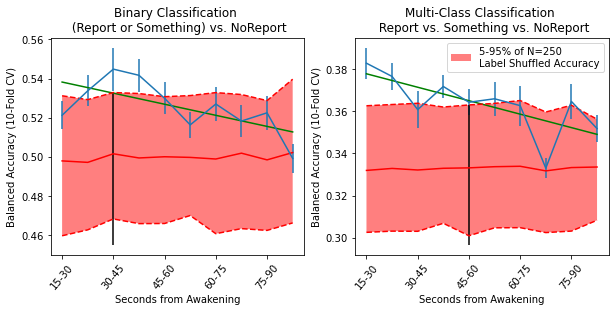

In [206]:
# plot data
fig, axs = plt.subplots(1,2,figsize=(10,4))

# sns.pointplot(x="Timerange", 
#               y="cv_accuracies", 
#               ci=df[df['class_no'] == 'binary']["std_err_m"].values/2,
#               data=df[df['class_no'] == 'binary'],
#               ax=axs[0],
#               join=False)
axs[0].errorbar(np.arange(0,10), 
                df[df['class_no'] == 'binary']["cv_accuracies"].values, 
                yerr=df[df['class_no'] == 'binary']["std_err_m"].values/2)

linear_model=np.polyfit(np.arange(10),
                        df[df['class_no'] == 'binary']["cv_accuracies"].values,
                        1)

linear_model_fn=np.poly1d(linear_model)
x_s=np.arange(10)
axs[0].plot(x_s,linear_model_fn(x_s),color="green")

import statsmodels.api as sm
from scipy import stats
X2 = sm.add_constant(x_s)
est = sm.OLS(df[df['class_no'] == 'binary']["cv_accuracies"].values, 
             X2)
est2 = est.fit()
print("binary p-values: " + str(est2.pvalues))
                               
# sns.pointplot(x="Timerange", 
#               y="cv_accuracies", 
#               ci="sd",
#               data=df[df['class_no'] == 'multi'],
#               ax=axs[1],
#              join=False) 

axs[1].errorbar(np.arange(0,10), 
                df[df['class_no'] == 'multi']["cv_accuracies"].values, 
                yerr=df[df['class_no'] == 'multi']["std_err_m"].values/2)

linear_model=np.polyfit(np.arange(10),
                        df[df['class_no'] == 'multi']["cv_accuracies"].values,
                        1)

linear_model_fn=np.poly1d(linear_model)
print(linear_model)
x_s=np.arange(10)
axs[1].plot(x_s,linear_model_fn(x_s),color="green")

X2 = sm.add_constant(x_s)
est = sm.OLS(df[df['class_no'] == 'multi']["cv_accuracies"].values, 
             X2)
est2 = est.fit()
print("multi p-values: " + str(est2.pvalues))

axs[1].plot(np.array(top_percentiles_multi), color="red", linestyle='dashed')
axs[1].plot(np.array(bot_percentiles_multi), color="red", linestyle='dashed')
axs[1].plot(np.array(mean_multi), color="red")
axs[1].fill_between(np.arange(0,10),np.array(bot_percentiles_multi), 
                                np.array(top_percentiles_multi), 
                                where=(np.array(top_percentiles_multi) > np.array(bot_percentiles_multi)), 
                                facecolor='red', alpha=0.5, 
                                label="5-95% of N=" + str(N) + " \nLabel Shuffled Accuracy")

axs[1].vlines(4,axs[1].get_ylim()[0],np.array(top_percentiles_multi)[4],colors="black")

x = np.arange(0, 9, 0.01)
y1 = np.percentile(nested_score_shuff, 5)
y2 = np.percentile(nested_score_shuff, 95)


axs[0].plot(np.array(top_percentiles_binary), color="red", linestyle='dashed')
axs[0].plot(np.array(bot_percentiles_binary), color="red", linestyle='dashed')
axs[0].plot(np.array(mean_binary), color="red")
axs[0].fill_between(np.arange(0,10),np.array(bot_percentiles_binary), 
                                np.array(top_percentiles_binary), 
                                where=(np.array(top_percentiles_binary) > np.array(bot_percentiles_binary)), 
                                facecolor='red', alpha=0.5, 
                                label="5-95% of N=" + str(N) + " \nLabel Shuffled Accuracy")

axs[0].vlines(2,axs[0].get_ylim()[0],np.array(top_percentiles_binary)[2],colors="black")

x = np.arange(0, 9, 0.01)
y1 = np.percentile(nested_score_shuff, 5)
y2 = np.percentile(nested_score_shuff, 95)


axs[0].set_title("Binary Classification \n (Report or Something) vs. NoReport")
axs[0].set_ylabel("Balanced Accuracy (10-Fold CV)")
axs[0].set_xlabel("Seconds from Awakening")

axs[1].set_title("Multi-Class Classification \n Report vs. Something vs. NoReport")
axs[1].set_ylabel("Balanecd Accuracy (10-Fold CV)")
axs[1].set_xlabel("Seconds from Awakening")

axs[0].set_xticklabels(["0-15","15-30","30-45","45-60","60-75","75-90","90-105","105-120","120-135","135-140"])
axs[1].set_xticklabels(["0-15","15-30","30-45","45-60","60-75","75-90","90-105","105-120","120-135","135-140"])

axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation = 50)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation = 50)
plt.legend()

plt.savefig("./figures/classifier.png", dpi=400, bbox_inches = "tight")

features: (1081, 185)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1081, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1081, 5)
features: (1081, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1081, 15)
groups: (1081,)
[5 1 1 6 9 3 1 1 7 1 2 1 1 4 8]
Optimal number of features : 7
['1-40Hz:Temporal', '1-40Hz:Parietal', '20-40Hz:Temporal', '20-40Hz:Parietal', '20-40Hz:Central', '1-20Hz:Temporal', '1-20Hz:Parietal']
features: (1081, 185)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1081, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1081, 5)
features: (1081, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1081, 15)
groups: (1081,)
[ 4  5  7  6 12  2 11  9  3  8  1  1  1  1 10]
Optimal nu

Text(0.5, 1.0, 'Multi-Class Classification, RFECV')

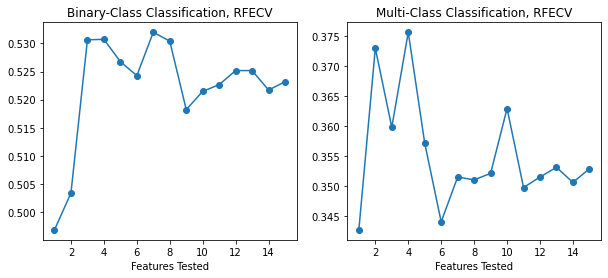

In [208]:
from sklearn.feature_selection import RFECV, RFE


fig, axs = plt.subplots(1,2,figsize=(10,4))

for class_no in range(2):
    if class_no == 0:
        timerange = 0.75
    elif class_no == 1:
        timerange = 0.25
    
    # spectral exponent features
    features = np.vstack(reduced_dataframe["SPECEXP_1-40_ALL_" + str(timerange)].values)
    print("features: " + str(features.shape))

    features = parcellate_features(features)
    print("features: " + str(features.shape))

    # add features
    features_intercept = np.vstack(reduced_dataframe["SPECEXP_20-40_ALL_" + str(timerange)].values)
    features_intercept = parcellate_features(features_intercept)
    print("features: " + str(features.shape))
    ## SPECTRAL EXPONENT + INTERCEPT
    features = np.concatenate((features,features_intercept),axis=1)
    print("features: " + str(features.shape))
    
    # add features
    features_intercept = np.vstack(reduced_dataframe["SPECEXP_1-40_ALL_" + str(timerange)].values)
    features_intercept = parcellate_features(features_intercept)
    ## SPECTRAL EXPONENT + INTERCEPT
    features = np.concatenate((features,features_intercept),axis=1)
    print("features: " + str(features.shape))

    groups = reduced_dataframe["ID"].values
    print("groups: " + str(groups.shape))

    # STANDARDIZE FEATURES
    features = preprocessing.scale(features)
    
    # Create the RFE object and compute a cross-validated score.
    if class_no == 0:
        
        clf = LogisticRegression(class_weight="balanced") 
#         clf = SVC(kernel="linear",class_weight="balanced")
        
        scoring = "balanced_accuracy"
        y = reduced_dataframe["REPORT_BINARY"].values
        
    else:
        clf = LogisticRegression(class_weight="balanced")
#         clf = SVC(kernel="linear",class_weight="balanced")
        
        scoring = "balanced_accuracy"
        y = reduced_dataframe["Q1ExperienceNum"].values

    # The "accuracy" scoring shows the proportion of correct classifications

    min_features_to_select = 1  # Minimum number of features to consider
    rfecv = RFECV(estimator=clf, 
                  step=1, 
                  cv=GroupKFold(10),
                  scoring=scoring,
                  min_features_to_select=min_features_to_select)
    rfecv.fit(features, 
              y, 
              groups=groups)

    
    ranking_1 = rfecv.ranking_
    print(ranking_1)
    print("Optimal number of features : %d" % rfecv.n_features_)
    
    names = ["1-40Hz:Frontal","1-40Hz:Temporal","1-40Hz:Parietal","1-40Hz:Occipital","1-40Hz:Central",
        "20-40Hz:Frontal","20-40Hz:Temporal","20-40Hz:Parietal","20-40Hz:Occipital","20-40Hz:Central",
        "1-20Hz:Frontal","1-20Hz:Temporal","1-20Hz:Parietal","1-20Hz:Occipital","1-20Hz:Central"]

    elements = [x for x in names if names.index(x) in list(np.where(ranking_1 < 2)[0])]
    print(elements)

    # Plot number of features VS. cross-validation scores

    axs[class_no].plot(range(min_features_to_select,
                   len(rfecv.grid_scores_) + min_features_to_select),
             rfecv.grid_scores_)
    axs[class_no].set_xlabel("Features Tested")

    
    axs[class_no].scatter(range(min_features_to_select,
                   len(rfecv.grid_scores_) + min_features_to_select),
             rfecv.grid_scores_)
    
axs[0].set_title("Binary-Class Classification, RFECV")
axs[1].set_title("Multi-Class Classification, RFECV")

## Out-of-Sample Prediction?

In [151]:
def parcellate_outofsample_features(features):
    
    raw = mne.io.read_raw_eeglab('/data/safmri/safmri_bids/derivatives/eeglab/sub-01/ses-eeg1/eeg/' +\
                             'sub-01_ses-eeg1_run-01_awak-1_hp_nbc_amica1_bsr_amica2_sc.set')

    ## ONLY FOR PLOTTING, MNE reads positions as meters
    for i in range(len(raw.info['chs'])):
        raw.info['chs'][i]['loc'] = raw.info['chs'][i]['loc']/15
        
    hist_bins = [["21","22","23","13","14","15","7","6","8"],

                 ["12","20","19","11","5",
                 "16","24","25","17","9"],


                 ["42","36","37","43","34","38","39","40","46","47"],

                 ["57","58","59","60","61","54","53","52","51","50","44","45"],

                 ["1","2","3","63"]
             ]

    groups = []
    for ch_names in hist_bins:
        indices = [raw.ch_names.index(ch_name) for ch_name in ch_names]
        groups.append(indices)

    inside185ch = sio.loadmat('../channel_location_file/inside185ch.mat')

    # labels/indices
    parcels_256labels = {"Frontal": np.array(list(map(int,hist_bins[0]))),
         "Temporal": np.array(list(map(int,hist_bins[1]))),
         "Parietal":np.array(list(map(int,hist_bins[2]))),
         "Occipital":np.array(list(map(int,hist_bins[3]))),
         "Central":np.array(list(map(int,hist_bins[4])))
         }

    # labels to indices
    parcels_185indices = {}

    for parcel in list(parcels_256labels.keys()):
        translate = []

        for i in range(0,len(parcels_256labels[parcel])):
            translate.append(np.where(np.squeeze(inside185ch['inside185ch']) == parcels_256labels[parcel][i])[0][0])

        parcels_185indices.update({parcel:np.array(list(map(int,translate)))})

    features_parc = features

    features_parc = np.stack((np.mean(features_parc[:, parcels_185indices["Frontal"]],axis=1),
              np.mean(features_parc[:, parcels_185indices["Temporal"]],axis=1),
              np.mean(features_parc[:, parcels_185indices["Parietal"]],axis=1),
              np.mean(features_parc[:, parcels_185indices["Occipital"]],axis=1),
              np.mean(features_parc[:, parcels_185indices["Central"]],axis=1)
             ),axis=1)
    
    return features_parc
                

In [152]:
def load_safmri_specexp(timerange):
    
    data_folder = '/data/tvanasse/nccam3/data/post_process_data/'
    from scipy.io import loadmat
    
    annots = loadmat(data_folder + 'safmri_spectral_slope_output.mat')

    nrem_dataframe = pd.read_csv('safmri_dataframe.csv')

    nrem_dataframe["SPECEXP_1-20_ALL"] = np.array(0).astype('object') #create object for 
    nrem_dataframe["OBS_1-20"] = np.array(0).astype('object') #create object for 
    nrem_dataframe["OBS_1-20_ALL"] = np.array(0).astype('object') #create object for 
    nrem_dataframe["FREQ_1-20"] = np.array(0).astype('object') #create object for

    nrem_dataframe["SPECEXP_20-40_ALL"] = np.array(0).astype('object') #create object for 
    nrem_dataframe["OBS_20-40"] = np.array(0).astype('object') #create object for 
    nrem_dataframe["OBS_20-40_ALL"] = np.array(0).astype('object') #create object for 
    nrem_dataframe["FREQ_20-40"] = np.array(0).astype('object') #create object for 

    nrem_dataframe["SPECEXP_1-40_ALL"] = np.array(0).astype('object') #create object for 
    nrem_dataframe["OBS_1-40"] = np.array(0).astype('object') #create object for 
    nrem_dataframe["OBS_1-40_ALL"] = np.array(0).astype('object') #create object for 
    nrem_dataframe["FREQ_1-40"] = np.array(0).astype('object') #create object for 

    # get spectral exponents & set timerange (1 or 2 minutes before awakening)
    for i in range(0,annots['output'].shape[1]):
#         print(annots['output']["path"][0][i][0])
        if (str(annots['output']['freqrange'][0][i][0]) == '[20 40]') & (annots['output']['timerange'][0][i][0][0] == timerange):
#             print(annots['output']['meanspectralexp'][0][i][0][0])
            nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["cleaned_path"] == annots['output']["path"][0][i][0]].index.values,"SPECEXP_20-40"] = annots['output']['meanspectralexp'][0][i][0][0]
            nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["cleaned_path"] == annots['output']["path"][0][i][0]].index.values,"INTERCEPT_20-40"] = annots['output']['meanintercept'][0][i][0][0]

            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["cleaned_path"] == annots['output']["path"][0][i][0]].index.values),"SPECEXP_20-40_ALL"] = annots['output']['spectralexp_all'][0][i][0].tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["cleaned_path"] == annots['output']["path"][0][i][0]].index.values),"OBS_20-40"] = annots['output']['obs_freq_avg'][0][i][0].tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["cleaned_path"] == annots['output']["path"][0][i][0]].index.values),"OBS_20-40_ALL"] = annots['output']['obs_freq_all'][0][i][0].tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["cleaned_path"] == annots['output']["path"][0][i][0]].index.values),"FREQ_20-40"] = annots['output']['freqbins'][0][i][0].tolist()

        elif (str(annots['output']['freqrange'][0][i][0]) == '[ 1 40]') & (annots['output']['timerange'][0][i][0][0] == timerange):
            nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["cleaned_path"] == annots['output']["path"][0][i][0]].index.values,"SPECEXP_1-40"] = annots['output']['meanspectralexp'][0][i][0][0]
            nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["cleaned_path"] == annots['output']["path"][0][i][0]].index.values,"INTERCEPT_1-40"] = annots['output']['meanintercept'][0][i][0][0]
            
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["cleaned_path"] == annots['output']["path"][0][i][0]].index.values),"SPECEXP_1-40_ALL"] = annots['output']['spectralexp_all'][0][i][0].tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["cleaned_path"] == annots['output']["path"][0][i][0]].index.values),"OBS_1-40"] = annots['output']['obs_freq_avg'][0][i][0].tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["cleaned_path"] == annots['output']["path"][0][i][0]].index.values),"OBS_1-40_ALL"] = annots['output']['obs_freq_all'][0][i][0].tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["cleaned_path"] == annots['output']["path"][0][i][0]].index.values),"FREQ_1-40"] = annots['output']['freqbins'][0][i][0].tolist()

        elif (str(annots['output']['freqrange'][0][i][0]) == '[ 1 20]') & (annots['output']['timerange'][0][i][0][0] == timerange):
            nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["cleaned_path"] == annots['output']["path"][0][i][0]].index.values,"SPECEXP_1-20"] = annots['output']['meanspectralexp'][0][i][0][0]
            nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["cleaned_path"] == annots['output']["path"][0][i][0]].index.values,"INTERCEPT_1-20"] = annots['output']['meanintercept'][0][i][0][0]
            
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["cleaned_path"] == annots['output']["path"][0][i][0]].index.values),"SPECEXP_1-20_ALL"] = annots['output']['spectralexp_all'][0][i][0].tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["cleaned_path"] == annots['output']["path"][0][i][0]].index.values),"OBS_1-20"] = annots['output']['obs_freq_avg'][0][i][0].tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["cleaned_path"] == annots['output']["path"][0][i][0]].index.values),"OBS_1-20_ALL"] = annots['output']['obs_freq_all'][0][i][0].tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["cleaned_path"] == annots['output']["path"][0][i][0]].index.values),"FREQ_1-20"] = annots['output']['freqbins'][0][i][0].tolist()

    return nrem_dataframe

In [153]:
safmri_dataframe = load_safmri_specexp(1)
print(len(safmri_dataframe))

144


In [154]:
safmri_dataframe["sub"].unique()
# plt.xticks(rotation=45)

array(['sub-01', 'sub-02', 'sub-03', 'sub-05', 'sub-06', 'sub-07',
       'sub-08', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-15',
       'sub-14', 'sub-17'], dtype=object)

<AxesSubplot:>

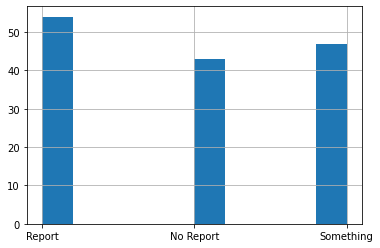

In [155]:
safmri_dataframe['Q1a'].hist()

In [156]:
# REMOVE OUTLIERS
safmri_dataframe["Z"] = stats.zscore(safmri_dataframe["SPECEXP_1-40"].values,axis=0)
print(safmri_dataframe[safmri_dataframe["Z"] > 5])
safmri_dataframe = safmri_dataframe[safmri_dataframe["Z"] < 5].reset_index(drop=True)

safmri_dataframe['REPORT_BINARY'] = 0
safmri_dataframe.loc[safmri_dataframe['Q1a'] != "No Report","REPORT_BINARY"] = 1

safmri_dataframe['Q1ExperienceNum'] = 1
safmri_dataframe.loc[safmri_dataframe['Q1a'] == "Something",'Q1ExperienceNum'] = 2
safmri_dataframe.loc[safmri_dataframe['Q1a'] == "Report",'Q1ExperienceNum'] = 3

         onset   duration     sample trial_type value             stim_file  \
26  20714.6592  10.284948  103573297   Stimulus  S  1  alarm_beep3_trim.wav   

     abs_onset_datetime  abs_onset_unix  awak_number sleep_score  ...  \
26  2021-03-23 04:30:05    1.616492e+09         14.0          N2  ...   

                                             OBS_1-40  \
26  [179.8870391845703, 180.15023803710938, 180.41...   

                                         OBS_1-40_ALL  \
26  [220.5084686279297, 221.4144744873047, 222.324...   

                                            FREQ_1-40 SPECEXP_20-40  \
26  [0.9765625, 0.9878549575805664, 0.999278008937...     -0.292542   

   INTERCEPT_20-40 SPECEXP_1-20 INTERCEPT_1-20  SPECEXP_1-40  INTERCEPT_1-40  \
26        3.682499     0.871986       2.166918       0.74202        2.197798   

           Z  
26  6.981088  

[1 rows x 56 columns]


<AxesSubplot:>

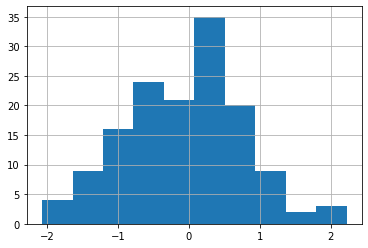

In [169]:
safmri_dataframe["Z"].hist()

In [170]:
# load spectral data function
def load_specexp(timerange):
    
    data_folder = '/data/tvanasse/nccam3/data/post_process_data/'
    from scipy.io import loadmat
    annots = loadmat(data_folder + 'spectral_slope_output.mat')

    nrem_dataframe = pd.read_csv('nrem_dataframe.csv')

    nrem_dataframe["SPECEXP_1-20_ALL"] = np.array(0).astype('object') #create object for 
    nrem_dataframe["OBS_1-20"] = np.array(0).astype('object') #create object for 
    nrem_dataframe["OBS_1-20_ALL"] = np.array(0).astype('object') #create object for 
    nrem_dataframe["FREQ_1-20"] = np.array(0).astype('object') #create object for

    nrem_dataframe["SPECEXP_20-40_ALL"] = np.array(0).astype('object') #create object for 
    nrem_dataframe["OBS_20-40"] = np.array(0).astype('object') #create object for 
    nrem_dataframe["OBS_20-40_ALL"] = np.array(0).astype('object') #create object for 
    nrem_dataframe["FREQ_20-40"] = np.array(0).astype('object') #create object for 

    nrem_dataframe["SPECEXP_1-40_ALL"] = np.array(0).astype('object') #create object for 
    nrem_dataframe["OBS_1-40"] = np.array(0).astype('object') #create object for 
    nrem_dataframe["OBS_1-40_ALL"] = np.array(0).astype('object') #create object for 
    nrem_dataframe["FREQ_1-40"] = np.array(0).astype('object') #create object for 

    # get spectral exponents & set timerange (1 or 2 minutes before awakening)
    for i in range(0,annots['output'].shape[1]):
#         print(i)
        if (str(annots['output']['freqrange'][0][i][0]) == '[20 40]') & (annots['output']['timerange'][0][i][0][0] == timerange):
            nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values,"SPECEXP_20-40"] = annots['output']['meanspectralexp'][0][i][0][0]
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"SPECEXP_20-40_ALL"] = annots['output']['spectralexp_all'][0][i][0].tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"OBS_20-40"] = annots['output']['obs_freq_avg'][0][i][0].tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"OBS_20-40_ALL"] = annots['output']['obs_freq_all'][0][i][0].tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"FREQ_20-40"] = annots['output']['freqbins'][0][i][0].tolist()

        elif (str(annots['output']['freqrange'][0][i][0]) == '[ 1 40]') & (annots['output']['timerange'][0][i][0][0] == timerange):
            nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values,"SPECEXP_1-40"] = annots['output']['meanspectralexp'][0][i][0][0]
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"SPECEXP_1-40_ALL"] = annots['output']['spectralexp_all'][0][i][0].tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"OBS_1-40"] = annots['output']['obs_freq_avg'][0][i][0].tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"OBS_1-40_ALL"] = annots['output']['obs_freq_all'][0][i][0].tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"FREQ_1-40"] = annots['output']['freqbins'][0][i][0].tolist()

        elif (str(annots['output']['freqrange'][0][i][0]) == '[ 1 20]') & (annots['output']['timerange'][0][i][0][0] == timerange):
            nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values,"SPECEXP_1-20"] = annots['output']['meanspectralexp'][0][i][0][0]
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"SPECEXP_1-20_ALL"] = annots['output']['spectralexp_all'][0][i][0].tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"OBS_1-20"] = annots['output']['obs_freq_avg'][0][i][0].tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"OBS_1-20_ALL"] = annots['output']['obs_freq_all'][0][i][0].tolist()
            nrem_dataframe.at[int(nrem_dataframe[nrem_dataframe["PATH_UNIQUE"] == annots['output']["path"][0][i][0].split("sub-",1)[1]].index.values),"FREQ_1-20"] = annots['output']['freqbins'][0][i][0].tolist()

    return nrem_dataframe

In [171]:
# get spectral exponent data 1 minute before awakening
nrem_dataframe = load_specexp(1)


 ## FILTER (subjects where there is at least one of each category)
check = np.load('./sub_q1_data/sub_reportorsomethingandnoreport_min1.npy')
print(check)
nrem_dataframe = nrem_dataframe[nrem_dataframe.ID.isin(check)].reset_index(drop=True)
nrem_dataframe = nrem_dataframe[nrem_dataframe['DIN_EVENTS_WITHIN_TWO_MINUTES'] == 1].reset_index(drop=True)
print(len(nrem_dataframe))

# assign either 0 (NoReport) or 1 (Report or Something) for concious experience
nrem_dataframe["REPORT_BINARY"] = 0
nrem_dataframe.loc[nrem_dataframe[(nrem_dataframe["Q1Experience"] != "NoReport")].index,
                       "REPORT_BINARY"] = 1

[2000 2001 2002 2004 2005 2006 2008 2010 2011 2012 2013 2016 2019 2022
 2023 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2037 2041 2043
 2045 2046 2047 2048 2049 2051 2052 2053 2054 2055 2056 2058 2059 2060
 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2075
 2078 2079 2080 2083 2085 2086 2087 2088 2091 2092 2094 2095 2096 2100
 2101 2102 2103 2104 2105 2106 2107 2108 2111 2112 2114 2115 2116 2121
 2122 2123 2126 2127 2128 2133 2134 2140 2142 2144]
1092


In [172]:
train_dataframe = nrem_dataframe.copy()
# spectral exponent features
train_features = np.vstack(train_dataframe["SPECEXP_1-40_ALL"].values)
print("features: " + str(train_features.shape))
train_features = parcellate_features(train_features)
print("features: " + str(train_features.shape))

# # add features
features_add = np.vstack(train_dataframe["SPECEXP_20-40_ALL"].values)
print("features: " + str(train_features.shape))
features_add = parcellate_features(features_add)
print("features: " + str(train_features.shape))
train_features = np.concatenate((train_features,features_add),axis=1)
print("features: " + str(train_features.shape))
# # add features
features_add = np.vstack(train_dataframe["SPECEXP_1-20_ALL"].values)
print("features: " + str(train_features.shape))
features_add = parcellate_features(features_add)
print("features: " + str(train_features.shape))
train_features = np.concatenate((train_features,features_add),axis=1)
print("features: " + str(train_features.shape))

train_groups = train_dataframe["ID"].values
# print("groups: " + str(groups.shape))

test_dataframe = safmri_dataframe.copy()
# spectral exponent features
test_features = np.vstack(test_dataframe["SPECEXP_1-40_ALL"].values)
print("features: " + str(test_features.shape))
test_features = parcellate_outofsample_features(test_features)
print("features: " + str(test_features.shape))


# # add features
features_add = np.vstack(test_dataframe["SPECEXP_20-40_ALL"].values)
print("features: " + str(test_features.shape))
features_add = parcellate_outofsample_features(features_add)
print("features: " + str(test_features.shape))
test_features = np.concatenate((test_features,features_add),axis=1)
print("features: " + str(test_features.shape))
# # add features
features_add = np.vstack(test_dataframe["SPECEXP_1-20_ALL"].values)
print("features: " + str(test_features.shape))
features_add = parcellate_outofsample_features(features_add)
print("features: " + str(test_features.shape))
test_features = np.concatenate((test_features,features_add),axis=1)
print("features: " + str(test_features.shape))


feat = {"data": np.array(train_features), 
        "subject":np.array(train_groups),
        "feature_order":["1-40Hz:Frontal","1-40Hz:Temporal","1-40Hz:Parietal","1-40Hz:Occipital","1-40Hz:Central",
            "20-40Hz:Frontal","20-40Hz:Temporal","20-40Hz:Parietal","20-40Hz:Occipital","20-40Hz:Central",
            "1-20Hz:Frontal","1-20Hz:Temporal","1-20Hz:Parietal","1-20Hz:Occipital","1-20Hz:Central"],
        "window": np.array([1])}
savemat("./data_features/sixtysec_training_X.mat", feat)

y_bin = {"data": np.array(test_features), 
        "subject":np.array(test_dataframe["sub"].values),
        "feature_order":["1-40Hz:Frontal","1-40Hz:Temporal","1-40Hz:Parietal","1-40Hz:Occipital","1-40Hz:Central",
            "20-40Hz:Frontal","20-40Hz:Temporal","20-40Hz:Parietal","20-40Hz:Occipital","20-40Hz:Central",
            "1-20Hz:Frontal","1-20Hz:Temporal","1-20Hz:Parietal","1-20Hz:Occipital","1-20Hz:Central"],
        "window": np.array([1])}
savemat("./data_features/sixtysec_test_X.mat", y_bin)


features: (1092, 185)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1092, 5)
features: (1092, 5)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1092, 5)
features: (1092, 10)
features: (1092, 10)
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
features: (1092, 10)
features: (1092, 15)
features: (143, 63)
Reading /data/safmri/safmri_bids/derivatives/eeglab/sub-01/ses-eeg1/eeg/sub-01_ses-eeg1_run-01_awak-1_hp_nbc_amica1_bsr_amica2_sc.fdt
features: (143, 5)
features: (143, 5)
Reading /data/safmri/safmri_bids/derivatives/eeglab/sub-01/ses-eeg1/eeg/sub-01_ses-eeg1_run-01_awak-1_hp_nbc_amica1_bsr_amica2_sc.fdt
features: (143, 5)
features: (143, 10)
features: (143, 10)
Reading /data/safmri/safmri_bids/derivatives/eeglab/sub-01/ses-eeg1/eeg/sub-01_ses-eeg1_run-01_awak-1_hp_nbc_amica1_bsr_amica2_sc.fdt
features: (143, 10)
features: (143, 15)


<ipython-input-151-703f1558462c>:4: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  'sub-01_ses-eeg1_run-01_awak-1_hp_nbc_amica1_bsr_amica2_sc.set')
<ipython-input-151-703f1558462c>:4: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  'sub-01_ses-eeg1_run-01_awak-1_hp_nbc_amica1_bsr_amica2_sc.set')
<ipython-input-151-703f1558462c>:4: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  'sub-01_ses-eeg1_run-01_awak-1_hp_nbc_amica1_bsr_amica2_sc.set')


In [173]:
# standardize features
train_features = preprocessing.scale(train_features)
test_features = preprocessing.scale(test_features)

In [174]:
train_dataframe['REPORT_BINARY'] = 0
train_dataframe.loc[train_dataframe['Q1Experience'] != "NoReport","REPORT_BINARY"] = 1

y_train = train_dataframe["REPORT_BINARY"].values
y_test = test_dataframe["REPORT_BINARY"].values

feat = {"data": np.array(y_train), 
        "subject":np.array(train_groups),
        "feature_order":["1-40Hz:Frontal","1-40Hz:Temporal","1-40Hz:Parietal","1-40Hz:Occipital","1-40Hz:Central",
            "20-40Hz:Frontal","20-40Hz:Temporal","20-40Hz:Parietal","20-40Hz:Occipital","20-40Hz:Central",
            "1-20Hz:Frontal","1-20Hz:Temporal","1-20Hz:Parietal","1-20Hz:Occipital","1-20Hz:Central"],
        "window": np.array([1])}
savemat("./data_features/sixtysec_training_y_bin.mat", feat)

y_bin = {"data": np.array(y_test), 
        "subject":np.array(test_dataframe["sub"].values),
        "feature_order":["1-40Hz:Frontal","1-40Hz:Temporal","1-40Hz:Parietal","1-40Hz:Occipital","1-40Hz:Central",
            "20-40Hz:Frontal","20-40Hz:Temporal","20-40Hz:Parietal","20-40Hz:Occipital","20-40Hz:Central",
            "1-20Hz:Frontal","1-20Hz:Temporal","1-20Hz:Parietal","1-20Hz:Occipital","1-20Hz:Central"],
        "window": np.array([1])}
savemat("./data_features/sixtysec_test_y_bin.mat", y_bin)

In [182]:
from sklearn.metrics import plot_confusion_matrix

n_jobs = 40


clf = LogisticRegression(class_weight="balanced")
p_grid = {'C': [0.00001,0.0001,0.001,0.01,0.1,1,5,10,100,1000]}
scoring = "balanced_accuracy"

# clf = SVC(kernel="linear",
#           class_weight="balanced",
#           probability=True,
#          )
# p_grid = {"C": [0.001,0.01,0.1,1,10,100,1000],
#           "gamma": [0.0001, 0.001,.01, .05, .1]}


cv = GroupKFold(n_splits=10)

grid = RandomizedSearchCV(estimator=clf,
                            param_distributions=p_grid,
                            cv=cv,
                            scoring=scoring,
                            return_train_score=True,
                            random_state=random_state,
                            n_jobs=n_jobs)

indices_from_rfe = np.where(np.array([5, 1, 1, 6, 9, 3, 1, 1, 7, 1, 2, 1, 1, 4, 8]) == 1)[0]
print("Using " + str(len(indices_from_rfe)) + " features from rfecv...")
print(['1-40Hz:Temporal', '1-40Hz:Parietal', '20-40Hz:Temporal', '20-40Hz:Parietal', '20-40Hz:Central', '1-20Hz:Temporal', '1-20Hz:Parietal'])


grid.fit(train_features[:,indices_from_rfe], 
         y_train, 
         groups=train_groups)

prediction = grid.predict(test_features[:,indices_from_rfe])
prob_estimates = grid.predict_proba(test_features[:,indices_from_rfe])

print("Balanced Accuracy: " + "{0:.2f}".format(balanced_accuracy_score(y_test, prediction)))
    
conf_mat = confusion_matrix(y_test, prediction)

Using 7 features from rfecv...
['1-40Hz:Temporal', '1-40Hz:Parietal', '20-40Hz:Temporal', '20-40Hz:Parietal', '20-40Hz:Central', '1-20Hz:Temporal', '1-20Hz:Parietal']
Balanced Accuracy: 0.62


TPR: 0.56
TNR: 0.67


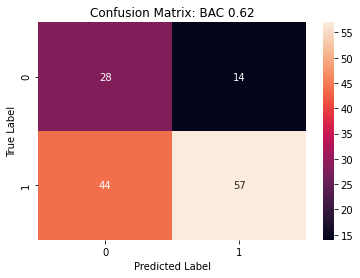

In [184]:
import seaborn as sns

cm = confusion_matrix(y_test, prediction)
f = sns.heatmap(cm, annot=True)

f.set(title="Confusion Matrix: BAC " + "{0:.2f}".format(balanced_accuracy_score(y_test, prediction)),
      xlabel="Predicted Label",
      ylabel="True Label",)

tn, fp, fn, tp = conf_mat.ravel()

print("TPR: " + "{0:.2f}".format(tp/(tp + fn)))
print("TNR: " + "{0:.2f}".format(tn/(tn + fp)))

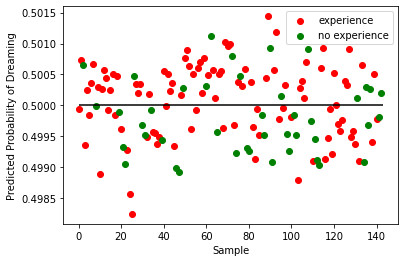

In [186]:
# plt.plot(prob_estimates[:,1])
plt.hlines(0.5,0,143, color="black")

# plt.hlines(np.mean(prob_estimates[:,1]),0,120, color="black")

plt.ylabel("Predicted Probability of Dreaming")
plt.xlabel("Sample")

plt.scatter(np.where(y_test == 1)[0], prob_estimates[:,1][np.where(y_test == 1)[0]], 
            color="red", label="experience")
plt.scatter(np.where(y_test == 0)[0], prob_estimates[:,1][np.where(y_test == 0)[0]], 
            color="green", label="no experience")

plt.legend()

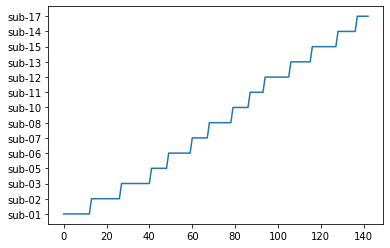

In [187]:
plt.plot(safmri_dataframe['sub'].values)